In [1]:
import numpy as np
import pandas as pd

In [2]:
import json
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)
data = list(parse_data('Sarcasm_Headlines_Dataset.json'))

In [3]:
data

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1},
 {'article_link': 'https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
  'headline': 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/jk-rowling-w

In [4]:
sentences = []
labels = []
for item in data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
train_size = int(0.7*len(sentences))
training_sentences = sentences[:train_size]
training_labels = labels[:train_size]
testing_sentences = sentences[train_size:]
testing_labels = labels[train_size:]
len(training_sentences)

18696

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
vocab_size = 10000
embed_dims =16
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)

In [12]:
word_index = tokenizer.word_index

In [13]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
train_padded  = pad_sequences(training_sequences, maxlen= 120 , padding= 'post', truncating= 'post')
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded  = pad_sequences(testing_sequences, maxlen= 120 , padding= 'post', truncating= 'post')

In [14]:
from tensorflow import keras 
from keras.layers import Embedding,Bidirectional,Dense,Dropout,LeakyReLU
from keras.models import Sequential
from keras.layers import LSTM

Using TensorFlow backend.


In [25]:
model =Sequential()
model.add(Embedding(vocab_size, embed_dims, input_length = 120))
model.add(Bidirectional(LSTM(24)))
model.add(Dropout(0.2))
model.add(Dense(24))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))

In [26]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 48)                7872      
_________________________________________________________________
dropout_5 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                1176      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 24)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [27]:
filepath = 'my_model_file.hdf5'
from keras.callbacks import EarlyStopping 
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min',restore_best_weights = True,patience = 3)
cp_callback =ModelCheckpoint(filepath,
                            monitor='val_loss',
                            save_best_only=True,
                            verbose=1)
ls = [es,cp_callback]

In [28]:
import numpy as np
num_epochs = 10
training_padded = np.array(train_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(test_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels),callbacks = ls,verbose=1)

C:\Users\91727\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18696 samples, validate on 8013 samples
Epoch 1/10
18696/18696 [==============================] - 138s 7ms/step - loss: 0.4214 - accuracy: 0.7907 - val_loss: 0.3284 - val_accuracy: 0.8555

Epoch 00001: val_loss improved from inf to 0.32839, saving model to my_model_file.hdf5
Epoch 2/10
18696/18696 [==============================] - 139s 7ms/step - loss: 0.2126 - accuracy: 0.9141 - val_loss: 0.3397 - val_accuracy: 0.8584

Epoch 00002: val_loss did not improve from 0.32839
Epoch 3/10
18696/18696 [==============================] - 138s 7ms/step - loss: 0.1277 - accuracy: 0.9530 - val_loss: 0.4100 - val_accuracy: 0.8522

Epoch 00003: val_loss did not improve from 0.32839
Epoch 4/10
18696/18696 [==============================] - 139s 7ms/step - loss: 0.0747 - accuracy: 0.9744 - val_loss: 0.5360 - val_accuracy: 0.8420

Epoch 00004: val_loss did not improve from 0.32839


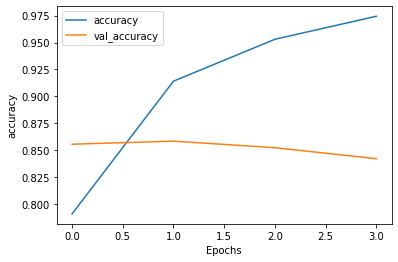

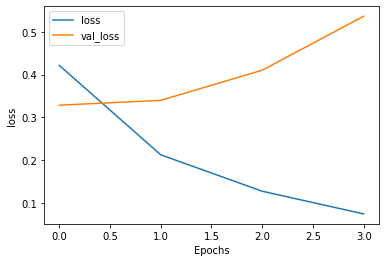

In [30]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [31]:
model.save('sarcasm.h5')

In [39]:
pred = model.predict(testing_padded)

array([0.8473841], dtype=float32)

In [51]:
for i in range(len(pred)):
    if pred[i] > 0.5 :
        pred[i] = 1
    else:
        pred[i] = 0

In [52]:
pred = pred.astype(np.int)

In [53]:
from sklearn.metrics import confusion_matrix 
cm= confusion_matrix(testing_labels,pred)

In [54]:
cm 

array([[3962,  574],
       [ 584, 2893]], dtype=int64)